# Text Classification using Deep Learning 

# LSTM (Long Short Term Memory Transformer) model for Sentiment Analysis

In [ ]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import tweepy
from textblob import TextBlob
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import requests
import nltk # for text manipulation
from nltk.stem.porter import *
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df=pd.read_csv("/content/drive/My Drive/covid19_tweets.csv")
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Republican #Capitalist; Sports lover - #BBN #Cincinnati #Reds #Bengals #Trump2020,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs #Resist,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that were always around me… https://t.co/Z0pOAlFXcW,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,"🖊️Official Twitter handle of Department of Information and Public Relations, Govt of Jammu & Kashmir",2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @airnewsalerts @ANI… https://t.co/MN0EEcsJHh,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [ ]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt
# create new column with removed @user
df['clean_text'] = np.vectorize(remove_pattern)(df['text'], '@[\w]*')
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0"
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey PR and - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu


In [ ]:
import re
df['clean_text'] = df['clean_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that…"
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey PR and - wouldn't it have made more sense to have the players pay their respects to the A…
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Republican #Capitalist; Sports lover - #BBN #Cincinnati #Reds #Bengals #Trump2020,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3,['COVID19'],Twitter for Android,False,Trump never once claimed #COVID19 was a hoax. We all claim that this effort to…


In [ ]:
# remove special characters, numbers, punctuations
df['clean_text'] = df['clean_text'].str.replace('[^a-zA-Z#]+',' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
# remove short words
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
df.head(2)
# create new variable tokenized tweet 
tokenized_tweet = df['clean_text'].apply(lambda x: x.split())
df.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_text
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",NaN,Twitter for iPhone,False,smelled the scent hand sanitizers today someone the past would think they were intoxicated that
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,NaN,Twitter for Android,False,Hey and wouldn have made more sense have the players pay their respects the


In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [ ]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
# change df['clean_text'] to tokenized_tweet

In [ ]:
df['clean_text']  = tokenized_tweet

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [ ]:
df['clean_text'].apply(lambda x: [item for item in x if item not in stop])

0                           [e, l, l,  , h, e,  , c, e, n,  , h, n,  , n,  ,  , e, n,  , h, e,  , p,  , w, u, l,  , h, n, k,  , h, e,  , w, e, r, e,  , n, x,  , h]
1                  [h, e,  , n,  , w, u, l, n,  , h, v, e,  , e,  , r, e,  , e, n,  , h, v, e,  , h, e,  , p, l, e, r,  , p,  , h, e, r,  , r, e, p, e, c,  , h, e]
2                                             [r, u, p,  , n, e, v, e, r,  , n, c,  , c, l,  , #, c, v,  , w,  , h, x,  , l, l,  , c, l,  , h,  , h,  , e, f, f, r]
3         [h, e,  , n, e,  , g, f,  , #, c, v,  , h,  , g, v, e,  , p, p, r, e, c,  , f, r,  , h, e,  , p, l,  , h, n, g,  , h,  , w, e, r, e,  , l, w,  , r, u, n]
4                                                                     [j, u, l,  , e,  , b, u, l, l, e, n,  , n, v, e, l,  , #, c, r, n, v, r, u, u, p,  , #, c, v]
                                                                                    ...                                                                            
179103          

In [ ]:
#creates a function that determines subjectivity and polarity from the textblob package
def getTextSubjectivity(clean_text):
    return TextBlob(clean_text).sentiment.subjectivity
def getTextPolarity(clean_text):
    return TextBlob(clean_text).sentiment.polarity
#applies these functions to the dataframe
df['Subjectivity'] = df['clean_text'].apply(getTextSubjectivity)
df['Polarity'] = df['clean_text'].apply(getTextPolarity)
#builds a function to calculate and categorize each tweet as Negative, Neutral, and Positive
def getTextAnalysis(a):
    if a < 0:
        return "Negative"
    elif a == 0:
        return "Neutral"
    else:
        return "Positive"
#creates another column called Score and applies the function to the dataframe
df['Score'] = df['Polarity'].apply(getTextAnalysis)

In [ ]:
new_df=df[['clean_text','Score']]

In [ ]:
data=new_df.head(20000)

## LSTM Neural Network using Keras

In [ ]:
import numpy as np
import tensorflow as tf

"""Loading the Dataset"""

#from tensorflow.keras.datasets import imdb

"""### **Data Preprocessing**"""

words=20000
max_length=100

from sklearn.model_selection import train_test_split

train,valid = train_test_split(data,test_size = 0.2,random_state=0,stratify = data.Score.values)
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

x_train = vectorizer.fit_transform(train.clean_text.values)
x_valid = vectorizer.transform(valid.clean_text.values)

y_train = train.Score.values
y_valid = valid.Score.values

"""Padding the Text"""

#x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train.todense, maxlen=max_length)

#x_valid = tf.keras.preprocessing.sequence.pad_sequences(x_valid.todense, maxlen=max_length)

word_size=words
word_size

embed_size=250

"""### Building a Recurrent Neural Network"""

data_model=tf.keras.Sequential()

# Embedding Layer
data_model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(x_train.shape[1],)))

# LSTM Layer
data_model.add(tf.keras.layers.LSTM(units=128, activation='tanh'))

# Output Layer
data_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

data_model.summary()

"""#### Compiling the model"""

data_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

"""#### Training the model"""

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(x_train, y_train)
predictions = mlp.predict(x_valid)
accuracy = accuracy_score(y_valid,predictions)
print("Training accuracy Score    : ",mlp.score(x_train,y_train))
print("Validation accuracy Score : ",accuracy )
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_valid,predictions))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28054, 128)        6400000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 6,531,713
Trainable params: 6,531,713
Non-trainable params: 0
_________________________________________________________________
Training accuracy Score    :  0.999825
Validation accuracy Score :  0.845
              precision    recall  f1-score   support

    Negative       0.70      0.74      0.72      1446
     Neutral       0.90      0.88      0.89      5115
    Positive       0.83      0.84      0.84      3439

    accuracy      

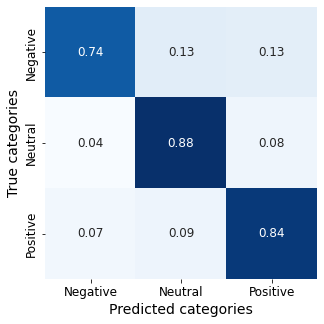

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_valid,predictions)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Negative','Neutral','Positive']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='Blues',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
!pip install pad_sequences
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

train,valid = train_test_split(data,test_size = 0.3,random_state=0,stratify = data.Score.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.clean_text.values)
X_valid = vectorizer.transform(valid.clean_text.values)

Y_train = train.Score.values
Y_valid = valid.Score.values
# model
embed_dim = 128
lstm_out = 192
max_fatures = 2000
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, Y_train)
prediction = mlp.predict(X_valid)
accuracy = accuracy_score(Y_valid,prediction)
print("Training accuracy Score    : ",mlp.score(X_train,Y_train))
print("Validation accuracy Score : ",accuracy )
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_valid,prediction))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25981, 128)        256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 25981, 128)       0         
 ropout1D)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 192)               246528    
                                                                 
 dense_1 (Dense)             (None, 2)                 386       
                                                                 
Total params: 502,914
Trainable params: 502,914
Non-trainable params: 0
_________________________________________________________________
None
Training a

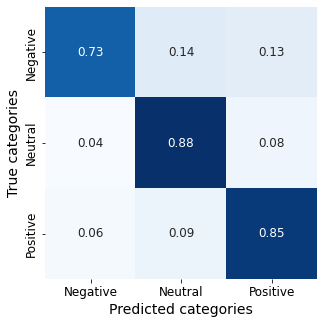

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_valid,prediction)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Negative','Neutral','Positive']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='Blues',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)